##SEQUENCE GENERATOR

In [ ]:
import numpy as np
import pandas as pd

class SequenceGenerator:
    """
    Generates sliding window sequences for LSTM input from the processed DataFrame.
    """
    def __init__(self, df, sequence_length=50, step=5):
        self.df = df.copy()
        self.sequence_length = sequence_length
        self.step = step
    def generate_sequences(self):
        """
        Returns:
            X: np.ndarray of shape (num_sequences, sequence_length, num_features)
            y: np.ndarray of shape (num_sequences,)
        """
        X, y = [], []
        feature_cols = [
    'TimeDelta',
    'SensorID_enc',
    'event_count',
    'progress_ratio',
    'TimeOfDay_enc',
    'SensorType_enc',
    'sensor_value_binary',
    'sensor_value_continuous'
    
]
        # Group by participant and task to avoid mixing data
        for (pid, tid), group in self.df.groupby(['participant_id', 'task_id']):
            group = group.reset_index(drop=True)
            label = group.loc[0, 'task_id']  # All rows in this group have the same label
            for start in range(0, len(group) - self.sequence_length + 1, self.step):
                end = start + self.sequence_length
                window = group.loc[start:end-1, feature_cols].values
                if window.shape[0] == self.sequence_length:
                    X.append(window)
                    y.append(label)
        X = np.array(X)
        y = np.array(y)
        return X, y



##MODEL TRAINING AND EVALUATION


===== Fold 1 =====
Fold 1 Test Accuracy: 0.955

===== Fold 2 =====
Fold 2 Test Accuracy: 0.924

===== Fold 3 =====
Fold 3 Test Accuracy: 0.942

=== Final Evaluation ===
Average Test Accuracy: 0.940

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        86
           1       0.00      0.00      0.00         4
           2       0.96      0.96      0.96       321
           3       1.00      0.73      0.85        56
           4       0.92      0.97      0.94       202

    accuracy                           0.94       669
   macro avg       0.75      0.73      0.74       669
weighted avg       0.94      0.94      0.94       669



d:\Projects\Home Activity Recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\Home Activity Recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\Home Activity Recognition\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

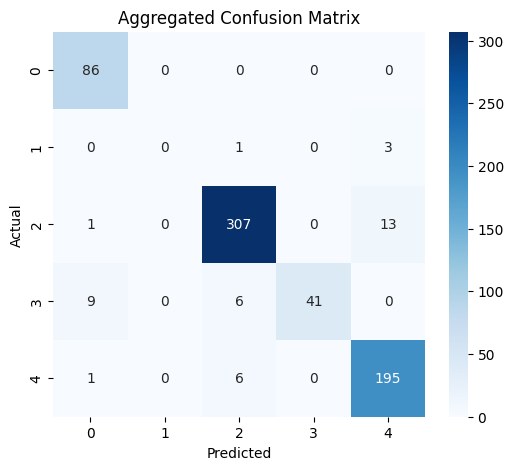

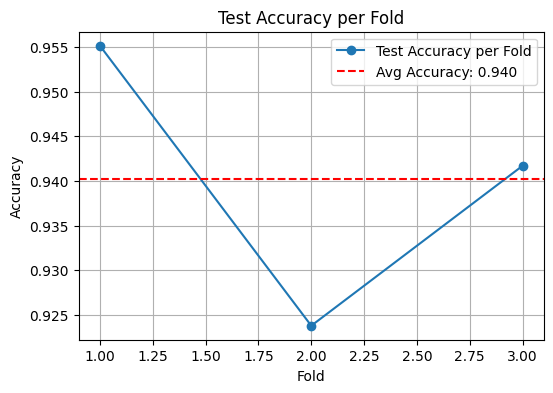

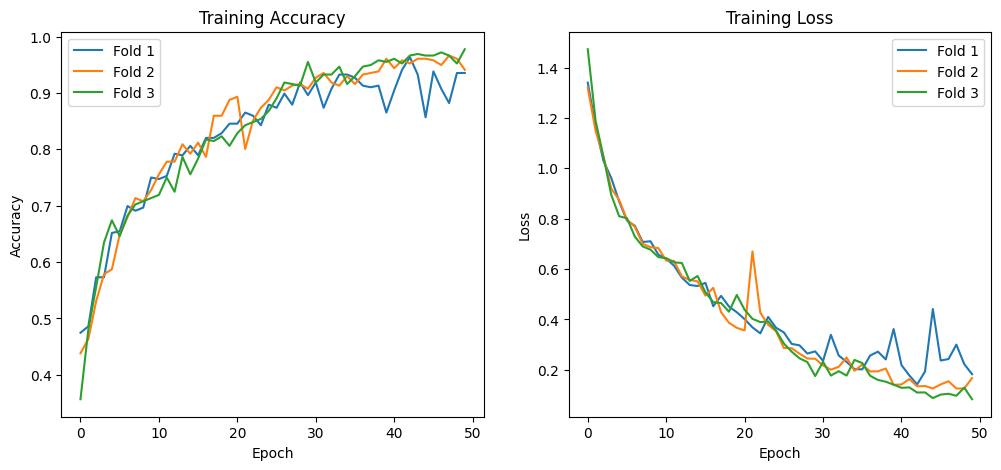

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Layer

# ----------------------- Attention Layer -----------------------
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# ----------------------- Model -----------------------
def build_cascade_ensemble_lstm_attention(input_shape, num_classes, n_cascade=3, lstm_units=64, dense_units=32, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    x = inputs
    for i in range(n_cascade):
        x = LSTM(lstm_units, return_sequences=True)(x)
        x = Dropout(dropout_rate)(x)
        if i < n_cascade - 1:
            repeated = tf.keras.layers.RepeatVector(input_shape[0])(x[:, -1, :])
            x = Concatenate()([inputs, repeated])
    x = Attention()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=out)

# ----------------------- Evaluation Utils -----------------------
def plot_conf_matrix(cm, class_names, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ----------------------- Main -----------------------
def main():
    PROCESSED_CSV = 'combined_dataset_II.csv'
    SEQUENCE_LENGTH = 30
    STEP = 5
    num_classes = 5

    df = pd.read_csv(PROCESSED_CSV)
    seq_gen = SequenceGenerator(df, sequence_length=SEQUENCE_LENGTH, step=STEP)
    X, y = seq_gen.generate_sequences()
    y_cat = to_categorical(y, num_classes)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []
    test_acc_list = []
    histories = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold} =====")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_cat[train_idx], y_cat[test_idx]
        y_test_labels = y[test_idx]

        model = build_cascade_ensemble_lstm_attention((SEQUENCE_LENGTH, X.shape[2]), num_classes)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            #callbacks=[early_stop],
            verbose=0
        )

        histories.append(history)

        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        acc = accuracy_score(y_test_labels, y_pred)
        test_acc_list.append(acc)

        all_y_true.extend(y_test_labels)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Test Accuracy: {acc:.3f}")

    # ----------------------- Final Results -----------------------
    avg_acc = np.mean(test_acc_list)
    print("\n=== Final Evaluation ===")
    print(f"Average Test Accuracy: {avg_acc:.3f}")

    print("\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))

    cm = confusion_matrix(all_y_true, all_y_pred)
    plot_conf_matrix(cm, class_names=[str(i) for i in range(num_classes)], title="Aggregated Confusion Matrix")

    # ----------------------- Plot Test Accuracy Curve -----------------------
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(test_acc_list)+1), test_acc_list, marker='o', label="Test Accuracy per Fold")
    plt.axhline(avg_acc, color='red', linestyle='--', label=f"Avg Accuracy: {avg_acc:.3f}")
    plt.title("Test Accuracy per Fold")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------- Plot Training Curves -----------------------
    plt.figure(figsize=(12,5))
    for i, hist in enumerate(histories, 1):
        plt.subplot(1,2,1)
        plt.plot(hist.history['accuracy'], label=f'Fold {i}')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(1,2,2)
        plt.plot(hist.history['loss'], label=f'Fold {i}')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    plt.subplot(1,2,1)
    plt.legend()
    plt.subplot(1,2,2)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()
